# Домашняя работа 4. Деревья

*Очень мягкий дедлайн: 26 ноября, 21:00*

*Очень жесткий дедлайн: 29 ноября, 21:00*


### Оценивание и штрафы

Максимальная оценка — 10 баллов и 1 бонус.

Есть опция забить на задание 2, взять готовый класс из `sklearn` и решить три последних задания с ним. Тогда максимальная оценка за домашку — 7 из 10 :)

Не списывайте, иначе всем участникам обнулим :)


### Задание 1 (2 балла)
Реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. Мы уже делали что-то подобное на семинаре: теперь немного усложните логику функции, в частности добавьте возможность выбора критерия информативности и типа признака. Протестируйте эту функцию на каком-нибудь датасете с бинарным таргетом. Можно взять готовый из `sklearn`.

In [225]:
from __future__ import annotations
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Используйте следующий функционал ошибки:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R)$ — критерий информативности (Джини или энтропия).


В этой реализации для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего улучшит функционал качества на данном шаге. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

Если вы захотите решить более сложный вариант домашки с учетом категориальных признаков, что сильно больше походит на реальность, напишите мне, и я выдам вам другой вариант домашки :) Он будет несколько сложнее, но интересней. Бонусов за это не будет :)

**Note:** постарайтесь решить без использования циклов для перебора порогов — впрочем, снимать баллы именно за этот момент не будем.

In [226]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    criterion: str = "gini",
    feature_type: str = "real"
    ) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или энтропии нужно выбирать порог с наименьшим значением.

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param criterion: либо `gini`, либо `entropy`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки
    :return q_values: вектор со значениями функционала ошибки для каждого из порогов в thresholds len(q_values) == len(thresholds)
    :return threshold_best: оптимальный порог
    :return q_value_best: значение функционала ошибки при оптимальном разбиении
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    
    get_pk = lambda target: np.unique(target, return_counts=True)[1]/len(target)
    
    gini = lambda pk: np.sum(pk*(1-pk))
    entropy = lambda pk: -np.sum(pk*np.log(pk))
    
    if criterion == "gini":
        L = gini
    elif criterion == "entropy":
        L = entropy
    else:
        raise ValueError("param criterion: либо `gini`, либо `entropy`")
             
    R = len(feature_vector)
    
    if feature_type == "categorical":
        thresholds = np.unique(feature_vector)
        
        q_values = []
        
        for t in thresholds:
            R_l = target_vector[feature_vector == t]
            R_r = target_vector[~(feature_vector == t)]
            
            Q = - len(R_l)/R*L(get_pk(R_l)) - len(R_r)/R*L(get_pk(R_r))
            q_values.append(Q)
            
        return thresholds, q_values, thresholds[np.argmax(q_values)], max(q_values)
    
    elif feature_type == "real":
        feature_vector = feature_vector.astype(np.float64)
        
        if np.all(feature_vector == feature_vector[0]):
            thresholds = np.array([feature_vector[0]])
        else:
            thresholds = (np.unique(feature_vector).astype(np.float64)[:-1]+np.unique(feature_vector).astype(np.float64)[1:])/2
        
        q_values = []
        
        for t in thresholds:
            R_l = target_vector[feature_vector <= t]
            R_r = target_vector[feature_vector > t]
            
            Q = - len(R_l)/R*L(get_pk(R_l)) - len(R_r)/R*L(get_pk(R_r))
            q_values.append(Q)
            
        return thresholds, q_values, thresholds[np.argmax(q_values)], max(q_values)
            
    else:
        raise ValueError("param feature_type: либо `real`, либо `categorical`")

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении по любому признаку из выбранного вами датасета.

In [227]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer().data
target = load_breast_cancer().target

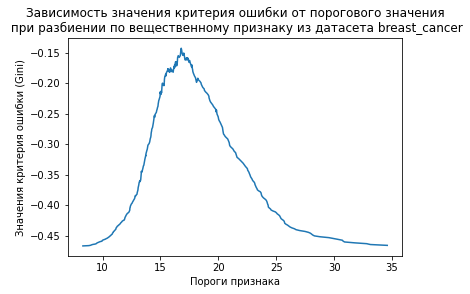

In [228]:
thresholds, q_values, _, _ = find_best_split(data[:, 20], target)

fig = plt.figure()
plt.plot(thresholds, q_values)
plt.title("Зависимость значения критерия ошибки от порогового значения\n при \
разбиении по вещественному признаку из датасета breast_cancer")
plt.xlabel("Пороги признака")
plt.ylabel("Значения критерия ошибки (Gini)")
plt.show()

### Задание 2 (3 балла)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node.

Построение дерева осуществите согласно базовому жадному алгоритму.

- Выбор лучшего разбиения необходимо производить по указанному критерию информативности.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- Ответ в листе: наиболее часто встречающийся класс.
- **1 бонусный балл** можно получить за поддержку параметров `max_depth`, `min_samples_leaf` и `min_samples_split`.

In [229]:
from collections import Counter

class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = 1,
        criterion: str = 'gini'
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self._criterion = criterion

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict,
        depth: int
    ) -> None:
        
        node["depth"] = depth
        
        # критерии останова
        if depth == self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common()[0][0]
            return
        if not self._min_samples_split is None:
            if sub_X.shape[0] < self._min_samples_split:
                node["type"] = "terminal"
                node["class"] = Counter(sub_y).most_common()[0][0]
                return
        
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, q_value_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, q_value = find_best_split(feature_vector, sub_y, self._criterion, feature_type)
            
            if q_value_best is None or q_value > q_value_best:
                feature_best = feature
                q_value_best = q_value

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature_best] < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = sub_X[:, feature_best] == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth = node["depth"]+1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth = node["depth"]+1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево
        в зависимости от значения предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # Критерий останова
        if node["type"] == "terminal":
            return node["class"]
        
        if self._feature_types[node["feature_split"]] == "real":
            if x[node["feature_split"]] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[node["feature_split"]] == "categorical":
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
                        
    def fit(self, X: np.ndarray, y: np.ndarray) -> DecisionTree:
        self._fit_node(X, y, self._tree, 0)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

### Задание 3 (2 балла)
Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [230]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
data = pd.read_csv("students.csv").to_numpy()[:, :-1]
target = pd.read_csv("students.csv").to_numpy()[:, -1]

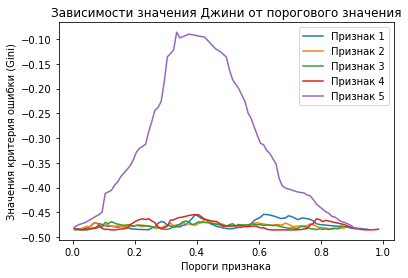

In [231]:
fig = plt.figure()
plt.title("Зависимости значения Джини от порогового значения")
plt.xlabel("Пороги признака")
plt.ylabel("Значения критерия ошибки (Gini)")
for i in range(5):
    plt.plot(find_best_split(data[:, i], target)[0], find_best_split(data[:, i], target)[1], label=f"Признак {i+1}")
plt.legend()
plt.show()

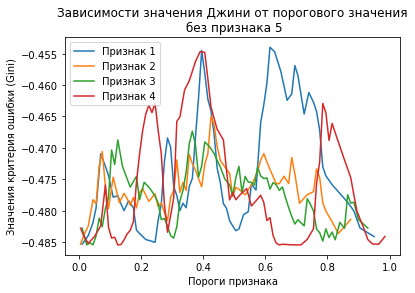

In [232]:
fig = plt.figure()
plt.title("Зависимости значения Джини от порогового значения\n \
без признака 5")
plt.xlabel("Пороги признака")
plt.ylabel("Значения критерия ошибки (Gini)")
for i in range(4):
    plt.plot(find_best_split(data[:, i], target)[0], find_best_split(data[:, i], target)[1], label=f"Признак {i+1}")
plt.legend()
plt.show()

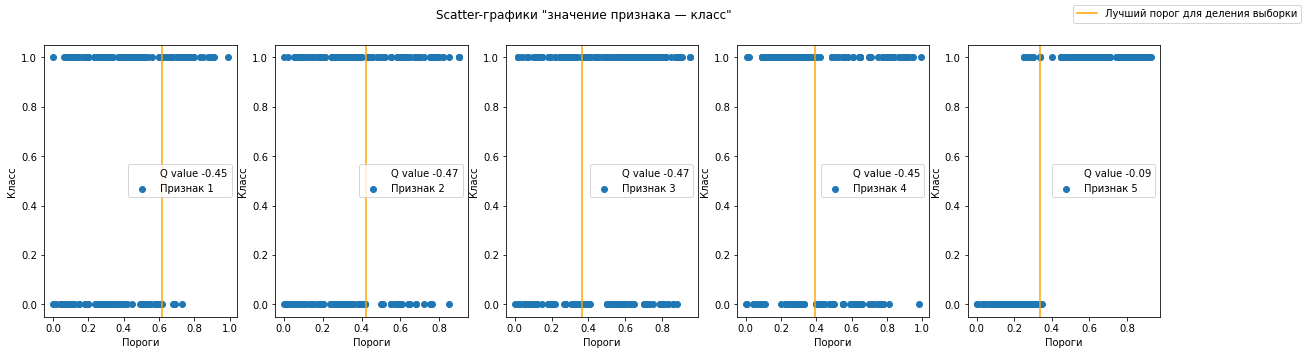

In [233]:
fig = plt.figure(figsize=(20,5))
axes = fig.subplots(nrows=1, ncols=5)

for i in range(5):
    _, _, best_threshold, q_value = find_best_split(data[:,i],target)
    axes[i].plot([], [], ' ', label=f"Q value {q_value:.{2}f}")
    axes[i].scatter(data[:,i],target, label=f"Признак {i+1}")
    line = axes[i].axvline(best_threshold, c='orange')
    axes[i].legend(loc='center right')
    axes[i].set_xlabel("Пороги")
    axes[i].set_ylabel("Класс")
fig.legend([line],["Лучший порог для деления выборки"], loc = "upper right")
fig.suptitle('Scatter-графики "значение признака — класс"')
plt.show()

### Задание 4 (1 балл)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
 - Нужно проводить деление на две выборки по признаку 5, так как на нем можно добиться наибольшого значения критерия Джини.
 - Да, результат согласуется с визуальной оценкой scatter-графиков. На scatter-графике 5 признака лучше всего видно, что данные можно хорошо разделить на два однородных множества.
 - График вогнутый, похож на параболу, нет резких скачков.
 - График имеет множество пиков и падений, много резких скачков. 

### Задание 5 (2 балла)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)). Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Посчитайте метрики качества.

In [234]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
fetch = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data").to_numpy()

In [235]:
data = fetch[:, 1:]
target = fetch[:, 0]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.5, random_state=42)

tree = DecisionTree(feature_types=["categorical"]*data.shape[1])
tree.fit(X_train, y_train)
y_predicted = tree.predict(X_test)

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

print(f"Accuracy score is {accuracy_score(y_predicted, y_test)}")
print(f"F1 score is {f1_score(y_predicted, y_test, pos_label = 'p')}")

Accuracy score is 1.0
F1 score is 1.0


Видим, что алгоритм идеально обучился и не ошибается на тестовых данных. Это неудивительно, так как можно выявить простое правило, которое в 100% случаях будет указывать на ядовитый гриб. В документации к датасету можно найти такой пример правила: `habitat=leaves.AND.cap-color=white`